In [1]:
import os 
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import pandas as pd
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.4)

import time
import warnings
warnings.filterwarnings('ignore')

rescale_size = 244
batch_size = 128

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


Загрузим данные и применим аугментации

In [2]:
transform = transforms.Compose([
    transforms.Resize((int(rescale_size * 1.25), int(rescale_size * 1.25))),
    transforms.RandomCrop(rescale_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_data = datasets.ImageFolder(
    root='/kaggle/input/journey-springfield/train/simpsons_dataset',
    transform=transform
)

print('Data folded successfully!\n')

train_idx, valid_idx = train_test_split(list(range(len(full_data))), train_size=0.8)
dataset = {
    'train': torch.utils.data.Subset(full_data, train_idx),
    'val': torch.utils.data.Subset(full_data, valid_idx)
}

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True, num_workers=2
    ),
    'val': torch.utils.data.DataLoader(
        dataset=dataset['val'], batch_size=batch_size, shuffle=False, num_workers=2
    ),
}

datasets_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
class_names = np.array(full_data.classes)

Data folded successfully!



In [3]:
transform = transforms.Compose([
    transforms.Resize((int(rescale_size * 1.05), int(rescale_size * 1.05))),
    transforms.CenterCrop(rescale_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_test = datasets.ImageFolder(
    root='/kaggle/input/journey-springfield/testset/',
    transform=transform
)

dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=batch_size)

Посмотрим на некоторые изображения

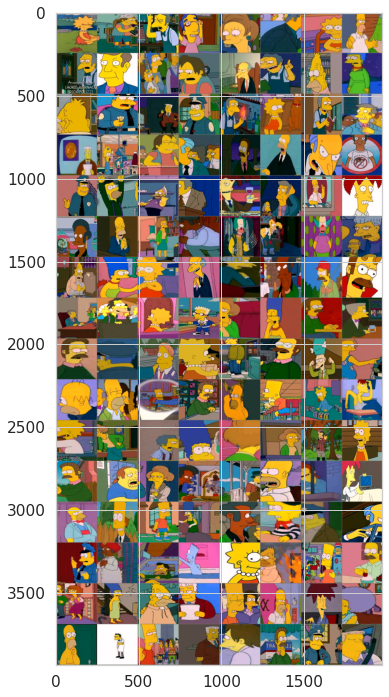

In [4]:
def imshow(inpt, title=None):
    inpt = inpt.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.299, 0.224, 0.225])
    inpt = std * inpt + mean
    inpt = np.clip(inpt, 0, 1)

    plt.figure(figsize=(15, 12))
    plt.imshow(inpt)

    if title is not None:
        plt.title(title)

inputs, classes = next(iter(dataloader['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out)

Напишем функцию для модели

In [5]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    '''

    main training code

    '''
    start = time.time()
    
    use_gpu = torch.cuda.is_available()
  
    best_mode_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], 'val': []}
    accs = {'train': [], 'val': []}

    pbar = trange(epochs, desc='Epoch')

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()

            curr_loss = 0.0
            curr_corrects = 0  

            for data in tqdm(dataloader[phase], leave=False, desc=f'{phase} iter'):
                inputs, labels = data
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                else:
                    inputs, labels = inputs, labels
        
                if phase == 'train':
                    optimizer.zero_grad()

                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                curr_loss += loss.item()
                curr_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = curr_loss / datasets_sizes[phase]
            epoch_acc = curr_corrects / datasets_sizes[phase]

            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
  
    time_elapsed = time.time() - start
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model, losses, accs

In [6]:
def plot_metrics(losses, accs):
    '''
    
    plots some metrics graphics
    
    '''
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 2, 1)
    plt.plot(losses['train'])
    plt.plot(losses['val'])
    plt.title('loss')
    plt.legend(list(losses.keys()))

    plt.subplot(1, 2, 2)
    plt.plot(accs['train'])
    plt.plot(accs['val'])
    plt.title('accuracy')
    plt.legend(list(accs.keys()))

    plt.show()

In [7]:
def evaluate(model):
    '''

    count accuracy on a test set

    '''

    model.eval()

    curr_correct = 0
    for data in dataloader['val']:
        inputs, labels = data

    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()

    output = model(inputs)
    _, preds = torch.max(output, 1)

    curr_correct += int(torch.sum(preds == labels))

    return curr_correct / datasets_sizes['val']

In [8]:
def predict(model, dataloader_test):
    probs = []
    model.eval()
    with torch.no_grad():
        
        for inputs, y in tqdm(dataloader_test):
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                
            preds = model(inputs).cpu()
            probs.append(preds)
            
    print(f'probs shape before softmax: {len(probs)}')
    probs = nn.functional.softmax(torch.cat(probs), dim=-1).numpy()
    print(f'probs shape after softmax: {probs.shape}')
    
    return probs

Згрузим модель ResNet50

In [9]:
model_resnet = models.resnet50(pretrained=True)

for param in model_resnet.parameters():
    param.require_grad = False

num_features = model_resnet.fc.in_features
model_resnet.classifier = nn.Linear(num_features, len(full_data.classes))

if torch.cuda.is_available():
    model_resnet = model_resnet.cuda()
    print('Training with cuda')
    
model_resnet.classifier

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Training with cuda


Linear(in_features=2048, out_features=42, bias=True)

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model_resnet.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model_resnet, losses_resnet, accs_resnet = train_model(model_resnet, loss_func, optimizer, exp_lr_scheduler, epochs=15)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

train iter:   0%|          | 0/131 [00:00<?, ?it/s]

val iter:   0%|          | 0/33 [00:00<?, ?it/s]

Training complete in 43m 54s
Best val Acc: 0.9756


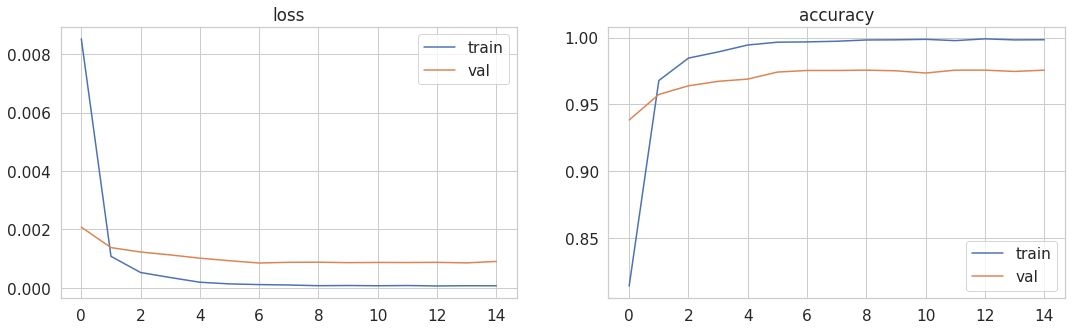

In [11]:
plot_metrics(losses_resnet, accs_resnet)

Предсказания на тестовой выборке для Кагла

In [12]:
test_filenames = [fn[0].split('/')[-1] for fn in dataset_test.imgs]

probs_resnet = predict(model_resnet, dataloader_test)
print(probs_resnet.shape)

preds_resnet = np.argmax(probs_resnet, axis=1)
preds_resnet = class_names[preds_resnet]

  0%|          | 0/8 [00:00<?, ?it/s]

probs shape before softmax: 8
probs shape after softmax: (991, 1000)
(991, 1000)


In [13]:
submission = pd.read_csv('/kaggle/input/journey-springfield/sample_submission.csv')
submission = pd.DataFrame({'id': test_filenames, 'Expected': preds_resnet}).sort_values('id')
submission.to_csv('./submission.csv', index=False)